In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
# import GradientBoostingClassifier, GradientBoostingRegressor

In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv('criteo-uplift-v2.1.csv')
print(df.shape)
print('treatment distribition:')
print(str(df.treatment.value_counts(normalize=True)))
df.head()

(13979592, 16)
treatment distribition:
1    0.85
0    0.15
Name: treatment, dtype: float64


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [5]:
df.groupby(['treatment', 'visit']).agg({'visit':[ 'count']})

visit
                    count
treatment visit          
0         0       2016832
          1         80105
1         0      11305831
          1        576824

In [6]:
df.groupby(['treatment', 'conversion']).agg({'conversion':[ 'count']})

conversion
                          count
treatment conversion           
0         0             2092874
          1                4063
1         0            11845944
          1               36711

In [7]:
# Ноутбук выполнялся в kaggle поэтому уменьшим датасет, чтобы не вылезти за допустимый размер памяти
df = df.sample(frac =.5, random_state = 42)

In [8]:
def qini_df(df):
    # 1. Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked[treatment_col] == 0)
    N_t = sum(ranked[treatment_col] == 1)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[(ranked[target_col] == 1)&(ranked[treatment_col]==0),'n_c1'] = 1
    ranked.loc[(ranked[target_col] == 1)&(ranked[treatment_col]==1),'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # Немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

In [9]:
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']
treatment_col = 'treatment'

In [10]:
# Разобъем нашу выборку на тестовую и валидационную

from sklearn.model_selection import train_test_split
target_col = 'visit' 
df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=42, test_size=0.3)
df_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
6791207,12.616365,10.059654,8.808206,4.679882,10.280525,4.115453,0.294443,4.833815,3.927254,13.190056,5.300375,-0.168679,0,0,0,0
8065346,12.616365,10.059654,8.986455,4.679882,10.280525,4.115453,0.294443,4.833815,3.943716,13.190056,5.300375,-0.168679,1,0,0,0
13583491,14.194121,10.059654,8.214383,-2.063975,10.280525,4.115453,-13.526963,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
10247891,12.616365,10.059654,8.513889,4.679882,10.280525,4.115453,0.294443,4.833815,3.856829,34.180688,5.300375,-0.168679,0,0,0,0
13117770,12.616365,10.059654,8.838556,4.679882,10.280525,4.115453,0.294443,4.833815,3.920995,13.190056,5.300375,-0.168679,0,0,0,0


In [11]:
mm_sc = MinMaxScaler(feature_range=(-1, 1))
df_train[feature_cols] = mm_sc.fit_transform(df_train[feature_cols].values)
df_test[feature_cols] = mm_sc.transform(df_test[feature_cols].values)
df_test['uplift_score'] = 0 

In [12]:
def s_learner(learner=CatBoostClassifier(random_seed=13, verbose=0)):
    model = BaseSClassifier(learner=learner)
    model.fit(X=df_train[feature_cols],
                  treatment=df_train[treatment_col],
                  y=df_train[target_col])
    uplift_vals = model.predict(np.array(df_test[feature_cols].values.copy()))
    df_test['uplift_score'] = uplift_vals
    return qini_df(df_test)

In [13]:
def t_learner(learner=CatBoostClassifier(random_seed=13, verbose=0)):
    model = BaseTClassifier(learner=learner)
    model.fit(X=df_train[feature_cols],
                  treatment=df_train[treatment_col],
                  y=df_train[target_col])
    uplift_vals = model.predict(np.array(df_test[feature_cols].values.copy()))
    df_test['uplift_score'] = uplift_vals
    return qini_df(df_test)

In [14]:
def x_learner(outcome_learner=LogisticRegression(random_state=42,verbose=0),
                           effect_learner=LinearRegression()):
    model = BaseXClassifier(outcome_learner=outcome_learner,
                            effect_learner=effect_learner)
    model.fit(X=df_train[feature_cols],
                  treatment=df_train[treatment_col],
                  y=df_train[target_col])
    uplift_vals = model.predict(np.array(df_test[feature_cols].values.copy()))
    df_test['uplift_score'] = uplift_vals
    return qini_df(df_test)

In [15]:
def r_learner(outcome_learner=LogisticRegression(random_state=42,verbose=0),
                            effect_learner=LinearRegression()):
    model = BaseRClassifier(outcome_learner=outcome_learner,
                            effect_learner=effect_learner)
    model.fit(X=df_train[feature_cols],
                  treatment=df_train[treatment_col],
                  y=df_train[target_col])
    uplift_vals = model.predict(np.array(df_test[feature_cols].values.copy()))
    df_test['uplift_score'] = uplift_vals
    return qini_df(df_test)

In [16]:
def uplift_tree():
    model = model = UpliftRandomForestClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')
    model.fit(X=df_train[feature_cols].values,
                  treatment=df_train[treatment_col].apply(str).values,
                  y=df_train[target_col].values)
    uplift_vals = model.predict(np.array(df_test[feature_cols].values.copy()))
    df_test['uplift_score'] = uplift_vals
    return qini_df(df_test)

In [17]:
learners_dict = {'s_learner': s_learner, 't_learner': t_learner, 'x_learner': x_learner, 'r_learner': r_learner, 'uplift_tree': uplift_tree}
qini_dict = {}

## target_col =  'visit'

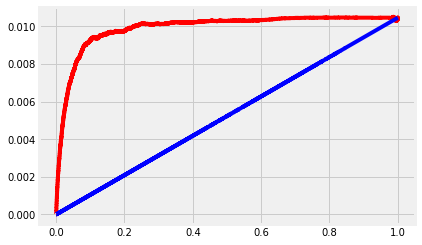

qini for s_learner with target = "visit": 9790.018909999997


In [18]:
k = 's_learner'
qini_dict[k] = learners_dict[k]()
print(f'qini for {k} with target = "{target_col}":', qini_dict[k])

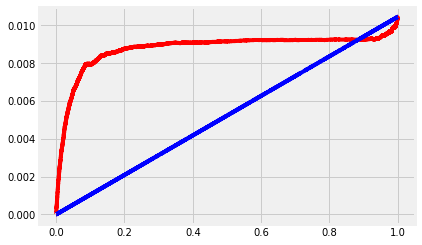

qini for t_learner with target = "visit": 7423.51715


In [19]:
k = 't_learner'
qini_dict[k] = learners_dict[k]()
print(f'qini for {k} with target = "{target_col}":', qini_dict[k])

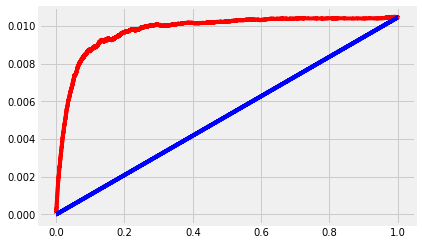

qini for x_learner with target = "visit": 9503.564569999988


In [20]:
k = 'x_learner'
qini_dict[k] = learners_dict[k]()
print(f'qini for {k} with target = "{target_col}":', qini_dict[k])

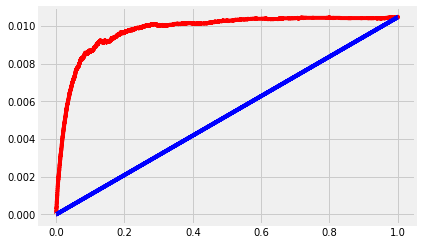

qini for r_learner with target = "visit": 9516.238790000007


In [21]:
k = 'r_learner'
qini_dict[k] = learners_dict[k]()
print(f'qini for {k} with target = "{target_col}":', qini_dict[k])

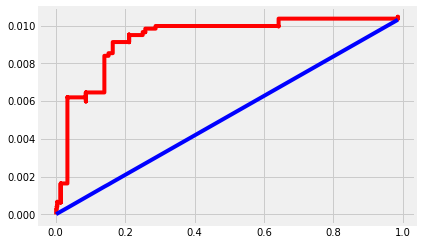

qini for uplift_tree with target = "visit": 8618.682769999994


In [22]:
k = 'uplift_tree'
qini_dict[k] = learners_dict[k]()
print(f'qini for {k} with target = "{target_col}":', qini_dict[k])

## target_col =  'conversion'

In [23]:
target_col =  'conversion'
df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=42, test_size=0.3)

mm_sc = MinMaxScaler(feature_range=(-1, 1))
df_train[feature_cols] = mm_sc.fit_transform(df_train[feature_cols].values)
df_test[feature_cols] = mm_sc.transform(df_test[feature_cols].values)
df_test['uplift_score'] = 0 

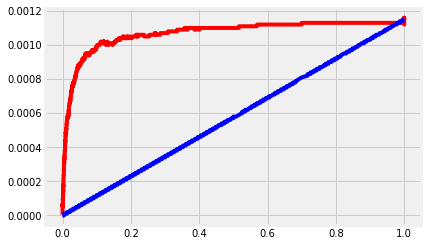

qini for s_learner with target = "conversion": 1034.71773


In [24]:
k = 's_learner'
qini_dict[k] = learners_dict[k]()
print(f'qini for {k} with target = "{target_col}":', qini_dict[k])

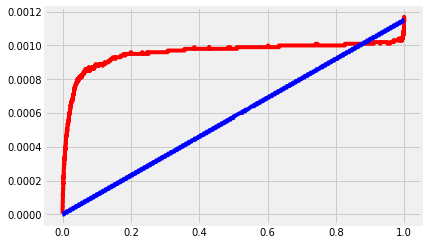

qini for t_learner with target = "conversion": 801.3469500000003


In [25]:
k = 't_learner'
qini_dict[k] = learners_dict[k]()
print(f'qini for {k} with target = "{target_col}":', qini_dict[k])

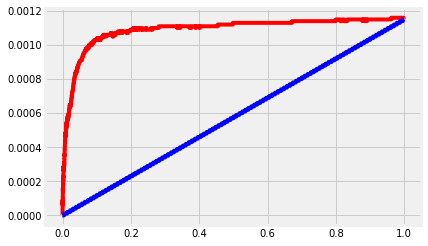

qini for x_learner with target = "conversion": 1080.27379


In [26]:
k = 'x_learner'
qini_dict[k] = learners_dict[k]()
print(f'qini for {k} with target = "{target_col}":', qini_dict[k])

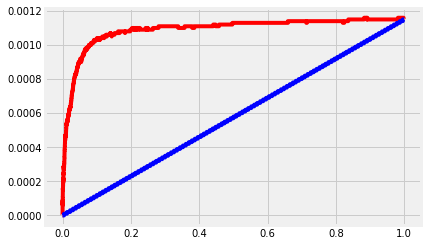

qini for r_learner with target = "conversion": 1079.8861400000005


In [27]:
k = 'r_learner'
qini_dict[k] = learners_dict[k]()
print(f'qini for {k} with target = "{target_col}":', qini_dict[k])

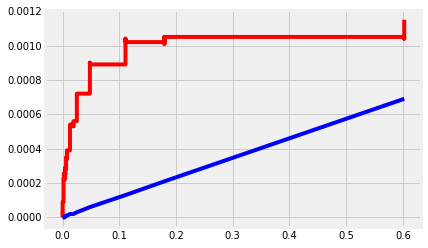

qini for uplift_tree with target = "conversion": 994.8261300000001


In [28]:
k = 'uplift_tree'
qini_dict[k] = learners_dict[k]()
print(f'qini for {k} with target = "{target_col}":', qini_dict[k])

### Результаты:

#### Самый высокий qini для целевой переменной 'visit' показал алгоритм s_learner:   9790
#### Самый высокий qini для целевой переменной 'conversion' показал алгоритм x_learner:  1080

#### Тем не менее x-learner и r-learner в обоих случаях показали результаты близкие к максимальным, что подсказывает сделать их алгоритмаи выбора для данного датасета.
#### Самым быстрым оказался алгоритм uplift_tree со средними значениями qini.